In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer  # Advanced imputation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error


In [4]:
# Step 1: Load and combine multiple CSV files from URLs
file_urls = [
    'https://raw.githubusercontent.com/hayatu4islam/Automotive_Diagnostics/main/OBD-II-Dataset/2017-07-05_Seat_Leon_RT_S_Stau.csv',
    'https://raw.githubusercontent.com/hayatu4islam/Automotive_Diagnostics/main/OBD-II-Dataset/2017-07-05_Seat_Leon_S_KA_Normal.csv',
    'https://raw.githubusercontent.com/hayatu4islam/Automotive_Diagnostics/main/OBD-II-Dataset/2017-07-06_Seat_Leon_KA_KA_Normal.csv',
    'https://raw.githubusercontent.com/hayatu4islam/Automotive_Diagnostics/main/OBD-II-Dataset/2017-07-06_Seat_Leon_KA_RT_Normal.csv',
    'https://raw.githubusercontent.com/hayatu4islam/Automotive_Diagnostics/main/OBD-II-Dataset/2017-07-07_Seat_Leon_S_RT_Normal.csv',
    'https://raw.githubusercontent.com/hayatu4islam/Automotive_Diagnostics/main/OBD-II-Dataset/2017-07-10_Seat_Leon_KA_KA_Stau.csv',
    'https://raw.githubusercontent.com/hayatu4islam/Automotive_Diagnostics/main/OBD-II-Dataset/2017-07-11_Seat_Leon_KA_KA_Stau.csv',
    'https://raw.githubusercontent.com/hayatu4islam/Automotive_Diagnostics/main/OBD-II-Dataset/2017-07-11_Seat_Leon_KA_S_Normal.csv',
    'https://raw.githubusercontent.com/hayatu4islam/Automotive_Diagnostics/main/OBD-II-Dataset/2017-07-11_Seat_Leon_S_RT_Frei.csv',
    'https://raw.githubusercontent.com/hayatu4islam/Automotive_Diagnostics/main/OBD-II-Dataset/2017-07-12_Seat_Leon_RT_S_Normal.csv',
    'https://raw.githubusercontent.com/hayatu4islam/Automotive_Diagnostics/main/OBD-II-Dataset/2017-07-12_Seat_Leon_S_RT_Normal.csv',
    'https://raw.githubusercontent.com/hayatu4islam/Automotive_Diagnostics/main/OBD-II-Dataset/2017-07-13_Seat_Leon_KA_KA_Normal.csv'
]
dfs = [pd.read_csv(url) for url in file_urls]
df = pd.concat(dfs, ignore_index=True)


In [5]:
# Clean column names (remove unwanted characters and strip whitespace)
df.columns = df.columns.str.replace('Â', '', regex=False)
df.columns = df.columns.str.strip()


In [6]:
# Step 2: Initial inspection & EDA
print(df.info())
print(df.describe())
print("Missing values in each column:\n", df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368341 entries, 0 to 368340
Data columns (total 11 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   Time                                       368341 non-null  object 
 1   Engine Coolant Temperature [°C]            368341 non-null  int64  
 2   Intake Manifold Absolute Pressure [kPa]    368329 non-null  float64
 3   Engine RPM [RPM]                           368317 non-null  float64
 4   Vehicle Speed Sensor [km/h]                368305 non-null  float64
 5   Intake Air Temperature [°C]                368293 non-null  float64
 6   Air Flow Rate from Mass Flow Sensor [g/s]  368281 non-null  float64
 7   Absolute Throttle Position [%]             368269 non-null  float64
 8   Ambient Air Temperature [°C]               368257 non-null  float64
 9   Accelerator Pedal Position D [%]           368245 non-null  float64
 10  Accelera

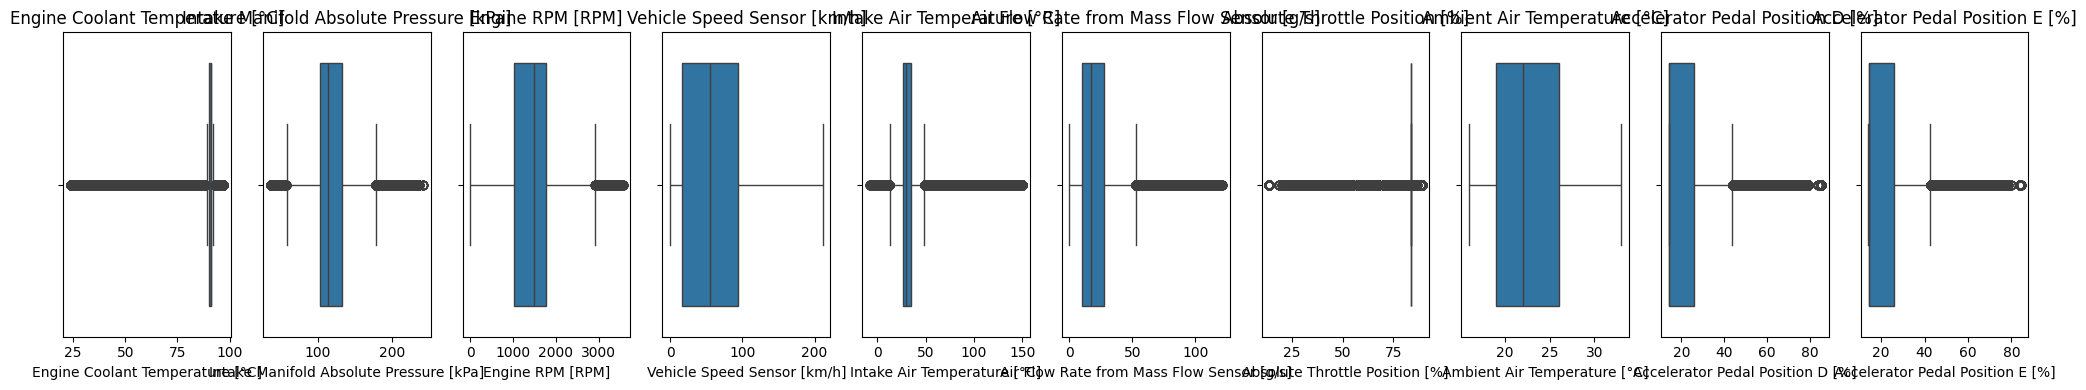

In [7]:
# Visualize distributions and outliers of numeric columns (limit to first 10 to avoid overcrowding)
num_cols = df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(20, 4))
for i, col in enumerate(num_cols[:10]):
    plt.subplot(1, 10, i + 1)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


In [8]:
# Step 3: Outlier treatment based on domain knowledge (clip coolant temp)
coolant_col = 'Engine Coolant Temperature [°C]'
if coolant_col in df.columns:
    df[coolant_col] = df[coolant_col].clip(60, 130)


In [9]:
# Step 4: Feature engineering
df['overheating'] = (df[coolant_col] > 100).astype(int)
rpm_col = 'Engine RPM [RPM]'
df['rpm_rolling_mean'] = df[rpm_col].rolling(window=5, min_periods=1).mean()
df['rpm_rolling_std'] = df[rpm_col].rolling(window=5, min_periods=1).std().fillna(0)


In [10]:
# Select features for modeling (ensure they exist)
features = [
    rpm_col,
    'Vehicle Speed Sensor [km/h]',
    coolant_col,
    'Absolute Throttle Position [%]',
    'Air Flow Rate from Mass Flow Sensor [g/s]',
    'rpm_rolling_mean',
    'rpm_rolling_std'
]
features = [f for f in features if f in df.columns]
X = df[features]
y_class = df['overheating']


In [11]:
# Step 5: Scale features (no PCA to avoid NaN issues)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# Step 7: Regression modeling with RandomForestRegressor (fast, handles NaNs if present)
regression_target = 'Air Flow Rate from Mass Flow Sensor [g/s]'
regression_features = [
    'Vehicle Speed Sensor [km/h]',
    rpm_col,
    'Absolute Throttle Position [%]'
]
if regression_target in df.columns and all(f in df.columns for f in regression_features):
    X_reg = df[regression_features]
    y_reg = df[regression_target]
    
    # Minimal imputation if needed (simple mean for any remaining NaNs, to keep it light)
    from sklearn.impute import SimpleImputer
    imputer_reg = SimpleImputer(strategy='mean')
    X_reg = imputer_reg.fit_transform(X_reg)
    

In [13]:
    # Scale features
    scaler_reg = StandardScaler()
    X_reg_scaled = scaler_reg.fit_transform(X_reg)
    
    # Split dataset
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg_scaled, y_reg, test_size=0.2, random_state=42)


In [14]:
    
    # Minimal imputation if needed (simple mean for any remaining NaNs, to keep it light)
    from sklearn.impute import SimpleImputer
    imputer_reg = SimpleImputer(strategy='mean')
    X_reg = imputer_reg.fit_transform(X_reg)


In [15]:
# Step 7: Regression modeling with RandomForestRegressor (fast, handles NaNs in X but not y)
regression_target = 'Air Flow Rate from Mass Flow Sensor [g/s]'
regression_features = [
    'Vehicle Speed Sensor [km/h]',
    'Engine RPM [RPM]',
    'Absolute Throttle Position [%]'
]
if regression_target in df.columns and all(f in df.columns for f in regression_features):
    X_reg = df[regression_features]
    y_reg = df[regression_target]
    


In [16]:
    # Minimal imputation for X_reg (handles any remaining NaNs in features)
    from sklearn.impute import SimpleImputer
    imputer_reg = SimpleImputer(strategy='mean')
    X_reg = imputer_reg.fit_transform(X_reg)
    
    # Handle NaNs in target y_reg: Drop rows where y_reg is NaN (avoids model errors)
    mask = pd.notna(y_reg)  # Create a mask for non-NaN targets
    X_reg = X_reg[mask]     # Filter X_reg to match
    y_reg = y_reg[mask]     # Filter y_reg
    print(f"After dropping NaNs: X_reg shape: {X_reg.shape}, y_reg shape: {y_reg.shape}")

After dropping NaNs: X_reg shape: (368281, 3), y_reg shape: (368281,)


In [17]:
    # Scale features
    scaler_reg = StandardScaler()
    X_reg_scaled = scaler_reg.fit_transform(X_reg)
    
    # Split dataset
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg_scaled, y_reg, test_size=0.2, random_state=42)


In [18]:
# Add these imports at the top (missing from previous code)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Now the optimized code will work
reg = RandomForestRegressor(random_state=42, n_jobs=-1)
param_dist_reg = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

random_reg = RandomizedSearchCV(reg, param_dist_reg, n_iter=10, cv=2,
                               scoring='neg_mean_squared_error', n_jobs=-1, 
                               random_state=42, verbose=2)
random_reg.fit(X_train_r, y_train_r)

print("Best params:", random_reg.best_params_)
print("Best CV score:", -random_reg.best_score_)



Fitting 2 folds for each of 10 candidates, totalling 20 fits


Best params: {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 20}
Best CV score: 52.831099072119045


Best regression params: {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 20}
Regression RMSE: 7.1550


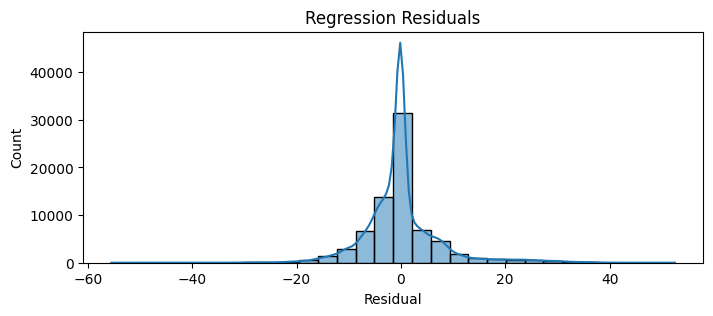

In [ ]:

if regression_target in df.columns and all(f in df.columns for f in regression_features):
    
    y_pred_r = random_reg.predict(X_test_r)
    from sklearn.metrics import mean_squared_error
    import numpy as np
    
    
    mse = mean_squared_error(y_test_r, y_pred_r)
    rmse = np.sqrt(mse)
    
    print("Best regression params:", random_reg.best_params_)
    print(f"Regression RMSE: {rmse:.4f}")
    
    # Residuals plot
    if len(y_test_r) > 0 and len(y_pred_r) > 0:
        residuals = y_test_r - y_pred_r
        if residuals.isna().sum() == 0:
            import matplotlib.pyplot as plt
            import seaborn as sns
            plt.figure(figsize=(8, 3))
            sns.histplot(residuals, bins=30, kde=True)
            plt.title('Regression Residuals')
            plt.xlabel('Residual')
            plt.show()
        else:
            print("Warning: Residuals contain NaNs; skipping plot.")
    else:
        print("No test data available for residuals plot.")
else:
    print(f"Regression target '{regression_target}' or features not found. Skipping regression.")



Top 5 Features for Anomalies:
                          feature  importance
1                Engine RPM [RPM]    0.549630
0     Vehicle Speed Sensor [km/h]    0.389584
2  Absolute Throttle Position [%]    0.060786


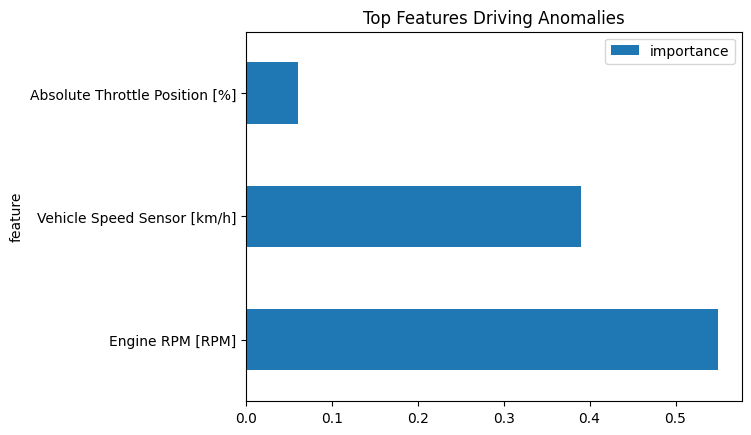

In [29]:
# Feature importance from regression model
feature_importance = pd.DataFrame({
    'feature': regression_features,
    'importance': random_reg.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 Features for Anomalies:")
print(feature_importance.head())
feature_importance.head(10).plot(kind='barh', x='feature', y='importance')
plt.title('Top Features Driving Anomalies')
plt.show()


Regression RMSE: 7.1550
R² Score: 0.8099 (closer to 1 is better)
Mean Absolute Error (MAE): 4.3933


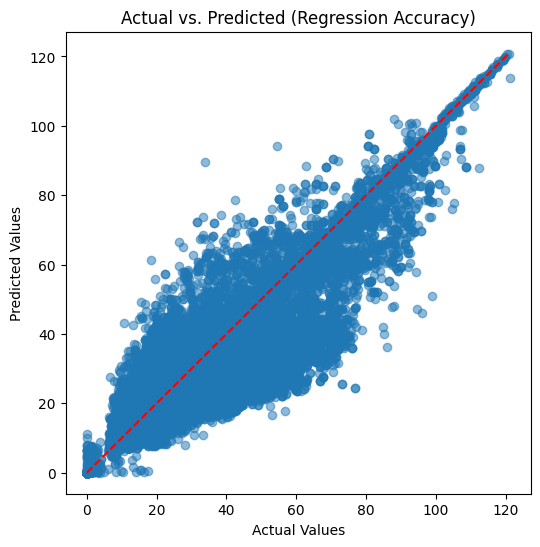

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

#  Use manual RMSE calculation (squared param removed in sklearn 1.6+)
mse = mean_squared_error(y_test_r, y_pred_r)
rmse = np.sqrt(mse)  # This gives you RMSE
print(f"Regression RMSE: {rmse:.4f}")

# Additional accuracy checks (these work fine)
r2 = r2_score(y_test_r, y_pred_r)
mae = mean_absolute_error(y_test_r, y_pred_r)
print(f"R² Score: {r2:.4f} (closer to 1 is better)")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Scatter plot (unchanged - works perfectly)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_r, y_pred_r, alpha=0.5)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--')  # Perfect fit line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted (Regression Accuracy)')
plt.show()


In [ ]:
 Use manual RMSE calculation (squared param removed in sklearn 1.6+)
mse = mean_squared_error(y_test_r, y_pred_r)
rmse = np.sqrt(mse)  # This gives you RMSE
print(f"Regression RMSE: {rmse:.4f}")

# Additional accuracy checks (these work fine)
r2 = r2_score(y_test_r, y_pred_r)
mae = mean_absolute_error(y_test_r, y_pred_r)
print(f"R² Score: {r2:.4f} (closer to 1 is better)")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Scatter plot (unchanged - works perfectly)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_r, y_pred_r, alpha=0.5)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--')  # Perfect fit line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted (Regression Accuracy)')
plt.show()


In [26]:
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# FIXED VERSION - Replace your entire block with this:
mse = mean_squared_error(y_test_r, y_pred_r)  # No 'squared' parameter
rmse = np.sqrt(mse)                           # Manual RMSE
r2 = r2_score(y_test_r, y_pred_r)
mae = mean_absolute_error(y_test_r, y_pred_r)

print("Best regression params:", random_reg.best_params_)  # Use random_reg, not grid_reg
print(f"Regression RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f} (closer to 1 is better)")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Best regression params: {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 20}
Regression RMSE: 7.1550
R² Score: 0.8099 (closer to 1 is better)
Mean Absolute Error (MAE): 4.3933


In [27]:
# ==============================
# FAULT & ANOMALY DETECTION
# ==============================

rpm_col = 'Engine RPM [RPM]'
coolant_col = 'Engine Coolant Temperature [°C]'
iat_col = 'Intake Air Temperature [°C]'
speed_col = 'Vehicle Speed Sensor [km/h]'
maf_col = 'Air Flow Rate from Mass Flow Sensor [g/s]'
map_col = 'Intake Manifold Absolute Pressure [kPa]'
throttle_col = 'Absolute Throttle Position [%]'